# 평론가 리뷰 키워드 분석

In [2]:
import pandas as pd

df = pd.read_csv("rotten_tomatoes_critic_reviews.csv")
df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [3]:
import re
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm

tqdm.pandas()

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# 전처리 함수
def preprocess_text(text):
    text_no_html = BeautifulSoup(str(text), "html.parser").get_text()
    expanded_text = contractions.fix(text_no_html)
    text_no_specials = re.sub(r'[^a-zA-Z]', ' ', expanded_text)
    text_clean = re.sub(r'\s+', ' ', text_no_specials).strip()
    text_lower = text_clean.lower()
    tokens = word_tokenize(text_lower)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return ' '.join(stemmed_tokens)


In [4]:
# from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
# import warnings

# warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning) # HTML경고 무시

# 결측치 제거
# df = df[['review_type','review_content']]
# df.dropna(subset=['review_content'], inplace=True)

# 복사본 생성 후 전처리 적용 (약 15분 소요)
# df_copy = df.copy()
# df_copy['cleaned_review'] = df_copy['review_content'].progress_apply(preprocess_text)
# df_copy.to_csv("cleaned_rotten_tomatoes_critic_reviews.csv", index=False, encoding='utf-8-sig')

# 따로 저장해둔걸로 실행 (위와 둘중 하나 주석처리)
df_copy = pd.read_csv("cleaned_rotten_tomatoes_critic_reviews.csv")

# 전처리 결과 확인
print(df_copy.head())

  review_type                                     review_content  \
0       Fresh  A fantasy adventure that fuses Greek mythology...   
1       Fresh  Uma Thurman as Medusa, the gorgon with a coiff...   
2       Fresh  With a top-notch cast and dazzling special eff...   
3       Fresh  Whether audiences will get behind The Lightnin...   
4      Rotten  What's really lacking in The Lightning Thief i...   

                                      cleaned_review  
0  fantasi adventur fuse greek mytholog contempor...  
1  uma thurman medusa gorgon coiffur writh snake ...  
2  top notch cast dazzl special effect tide teen ...  
3  whether audienc get behind lightn thief hard p...  
4  realli lack lightn thief genuin sens wonder th...  


In [5]:
pd.set_option('display.max_colwidth', 200)

# Fresh → positive, Rotten → negative로 라벨링
df_copy['sentiment'] = df_copy['review_type'].apply(lambda x: 'positive' if x == 'Fresh' else 'negative')

# 긍정 / 부정 리뷰 분리
df_pos = df_copy[df_copy['sentiment'] == 'positive'][['review_type','sentiment','review_content','cleaned_review']]
df_neg = df_copy[df_copy['sentiment'] == 'negative'][['review_type','sentiment','review_content','cleaned_review']]

# 확인
df_pos.head()

,review_type,sentiment,review_content,cleaned_review
0,Fresh,positive,A fantasy adventure that fuses Greek mythology to contemporary American places and values. Anyone around 15 (give or take a couple of years) will thrill to the visual spectacle,fantasi adventur fuse greek mytholog contemporari american place valu anyon around give take coupl year thrill visual spectacl
1,Fresh,positive,"Uma Thurman as Medusa, the gorgon with a coiffure of writhing snakes and stone-inducing hypnotic gaze is one of the highlights of this bewitching fantasy",uma thurman medusa gorgon coiffur writh snake stone induc hypnot gaze one highlight bewitch fantasi
2,Fresh,positive,"With a top-notch cast and dazzling special effects, this will tide the teens over until the next Harry Potter instalment.",top notch cast dazzl special effect tide teen next harri potter instal
3,Fresh,positive,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big ...",whether audienc get behind lightn thief hard predict overal entertain introduct promis new world consum shadow potter big break free
7,Fresh,positive,"Percy Jackson isn't a great movie, but it's a good one, trotting out kernels of Greek mythology like so many Disney Channel references.",perci jackson great movi good one trot kernel greek mytholog like mani disney channel refer


In [6]:
import pandas as pd
import nltk
from collections import Counter

ACCEPTED_POS = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')

# 명사, 형용사 필터링 함수
def filter_pos_adj(tokens):
    tagged = nltk.pos_tag(tokens)
    filtered = [word for word, pos in tagged if pos in ACCEPTED_POS]
    return filtered

# 단어 빈도 계산 함수
def get_filtered_word_freq(text_series):
    
    # NaN 제거 및 문자열 변환
    text_series = text_series.dropna().astype(str)

    # 텍스트 합치고 토큰화
    tokens = ' '.join(text_series).split()

    # 품사 필터링
    filtered_tokens = filter_pos_adj(tokens)

    # 단어 빈도 계산
    word_counts = Counter(filtered_tokens)

    # DataFrame 변환 후 빈도 내림차순 정렬
    df_freq = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
    df_freq_sorted = df_freq.sort_values(by='Frequency', ascending=False)

    return df_freq_sorted.head(30), word_counts


In [7]:
# 긍정 빈도 정렬
df_pos_freq, pos_word_counts = get_filtered_word_freq(df_pos["cleaned_review"])
print("Positive reviews top keywords:\n", df_pos_freq)

Positive reviews top keywords:
           Word  Frequency
164       film     139043
121       movi      82040
407       time      35318
254      stori      34127
268    perform      33637
57        good      32479
208    charact      30533
129       work      27607
228   director      25192
288        way      24909
543     comedi      24180
95        best      24129
56       great      23140
301       full      22665
13        year      21657
667       life      21223
83      action      21144
64         fun      20162
1009      much      19618
675      drama      17990
527      funni      17529
48       world      16206
47         new      16050
277     review      15905
1133     power      14902
1040       man      14793
1179  thriller      14498
910        end      14497
2044   spanish      14289
71       thing      14188


In [8]:
# 부정 빈도 정렬
df_neg_freq, neg_word_counts = get_filtered_word_freq(df_neg["cleaned_review"])
print("Negative reviews top keywords:\n", df_neg_freq)

Negative reviews top keywords:
           Word  Frequency
239       film      62647
12        movi      57200
98     charact      19304
165       time      18134
180       much      17405
382      stori      16532
275       good      16014
477     comedi      14675
27         bad      12008
208        way      11877
294   director      11498
54         end      11467
60       littl      11308
148       plot      10905
602     action      10852
76        feel      10641
6        thing      10080
197       work       9946
423       full       8935
1023   perform       8387
618     script       8385
136   interest       7962
917      watch       7705
210       look       7563
1         lack       7508
123       mani       7299
282     moment       7265
129        tri       7198
426       year       7165
304      scene       7107


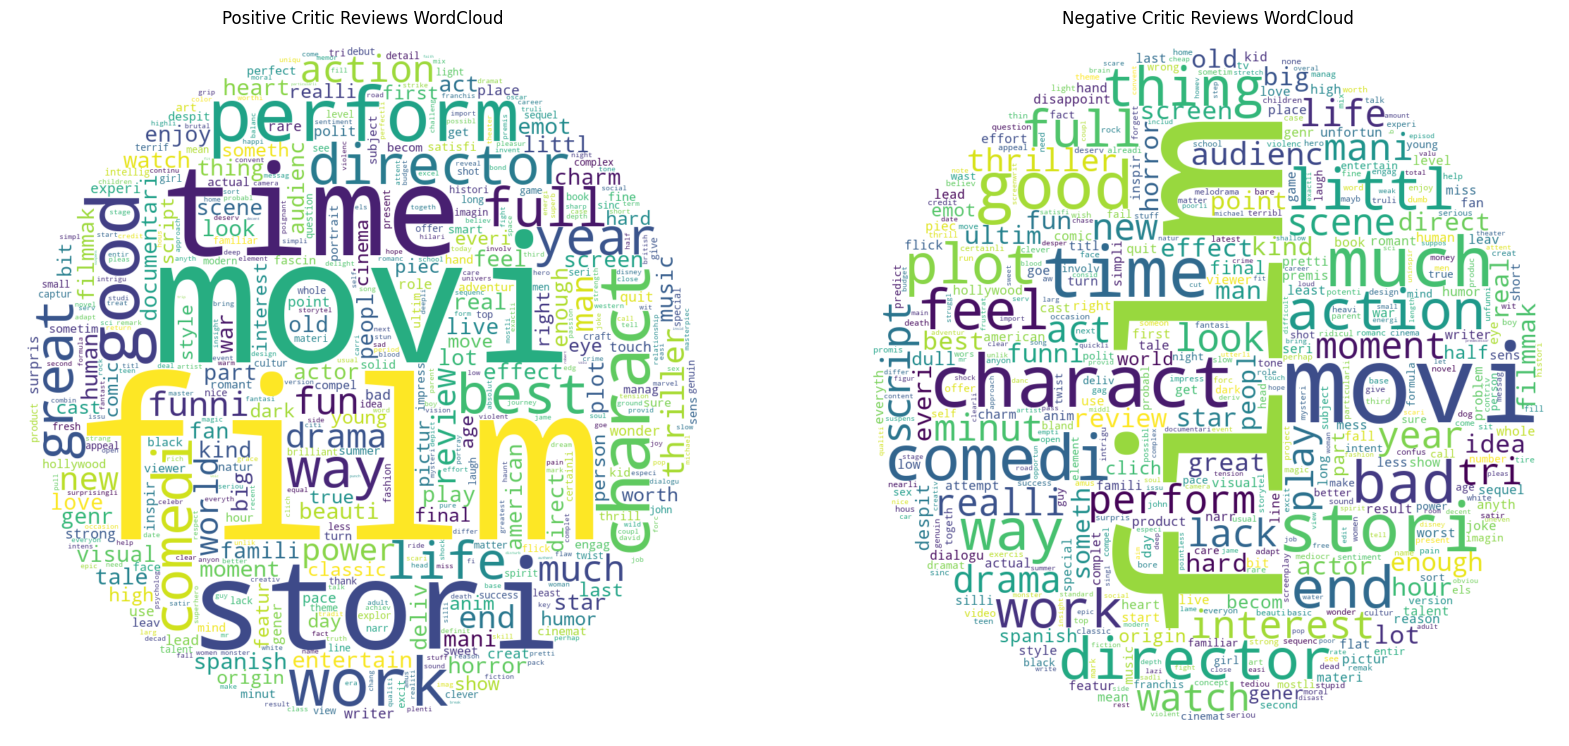

In [9]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 마스크 생성 (원형)
x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 480 ** 2
mask = 255 * mask.astype(int)

# 워드클라우드 생성 함수
def create_wordcloud(word_counts, mask):
    return WordCloud(
        width=1000,
        height=1000,
        max_words=500,
        mask=mask,
        background_color='white'
    ).generate_from_frequencies(word_counts)

pos_wordcloud = create_wordcloud(pos_word_counts, mask)
neg_wordcloud = create_wordcloud(neg_word_counts, mask)

# 플롯 생성 - 1행 2열
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 긍정 워드클라우드
axs[0].imshow(pos_wordcloud, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Positive Critic Reviews WordCloud')

# 부정 워드클라우드
axs[1].imshow(neg_wordcloud, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Negative Critic Reviews WordCloud')

plt.show()

In [10]:
from gensim import corpora

# NaN 제거
df_pos = df_pos[df_pos["cleaned_review"].notna()]
df_neg = df_neg[df_neg["cleaned_review"].notna()]

# 각 리뷰를 단어 단위로 나눔 (문서 단위 토큰화)
tokenized_pos_doc = df_pos['cleaned_review'].apply(lambda x: x.split())
tokenized_neg_doc = df_neg['cleaned_review'].apply(lambda x: x.split())

# 필터링 적용
tokenized_pos_doc = tokenized_pos_doc.apply(filter_pos_adj)
tokenized_neg_doc = tokenized_neg_doc.apply(filter_pos_adj)

# 각 단어에 고유 ID를 부여 (사전 생성)
pos_dictionary = corpora.Dictionary(tokenized_pos_doc)
neg_dictionary = corpora.Dictionary(tokenized_neg_doc)

# 각 문서를 "단어 ID + 단어 개수" 형식으로 변환
pos_corpus = [pos_dictionary.doc2bow(text) for text in tokenized_pos_doc]
neg_corpus = [neg_dictionary.doc2bow(text) for text in tokenized_neg_doc]

In [11]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt

# 평가 함수
def evaluate_lda_model(tokenized_doc, dictionary, corpus, label):
    coherence_values = []
    perplexity_values = []

    for num_topics in range(2, 13, 2):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dictionary,
                         passes=4,
                         alpha='symmetric',
                         eta='auto',
                         random_state=100)

        coherence_model = CoherenceModel(model=model,
                                         texts=tokenized_doc,
                                         dictionary=dictionary,
                                         coherence='c_v')

        coherence = coherence_model.get_coherence()
        log_perplexity = model.log_perplexity(corpus)
        perplexity = 2 ** (-log_perplexity)

        coherence_values.append(coherence)
        perplexity_values.append(perplexity)

        print(f"[{label}] num_topics={num_topics} | Coherence={coherence:.4f} | Perplexity={perplexity:.2f}")

    return {
        "coherence": coherence_values,
        "perplexity": perplexity_values
    }

# 시각화 함수
def plot_lda_metrics(result_dict, label=""):
    coherence = result_dict["coherence"]
    perplexity = result_dict["perplexity"]
    topics = range(2, 13, 2)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1행 2열

    # Coherence 그래프
    axes[0].plot(topics, coherence, marker='o', color='blue')
    axes[0].set_title(f'Coherence Score - {label}')
    axes[0].set_xlabel('Number of Topics')
    axes[0].set_ylabel('Coherence')
    axes[0].grid(True)

    # Perplexity 그래프
    axes[1].plot(topics, perplexity, marker='s', color='green')
    axes[1].set_title(f'Perplexity Score - {label}')
    axes[1].set_xlabel('Number of Topics')
    axes[1].set_ylabel('Perplexity')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

[POSITIVE] num_topics=2 | Coherence=0.2868 | Perplexity=323.49
[POSITIVE] num_topics=4 | Coherence=0.3390 | Perplexity=361.77
[POSITIVE] num_topics=6 | Coherence=0.3407 | Perplexity=406.81
[POSITIVE] num_topics=8 | Coherence=0.3320 | Perplexity=476.19
[POSITIVE] num_topics=10 | Coherence=0.3401 | Perplexity=673.26
[POSITIVE] num_topics=12 | Coherence=0.3246 | Perplexity=1592.67


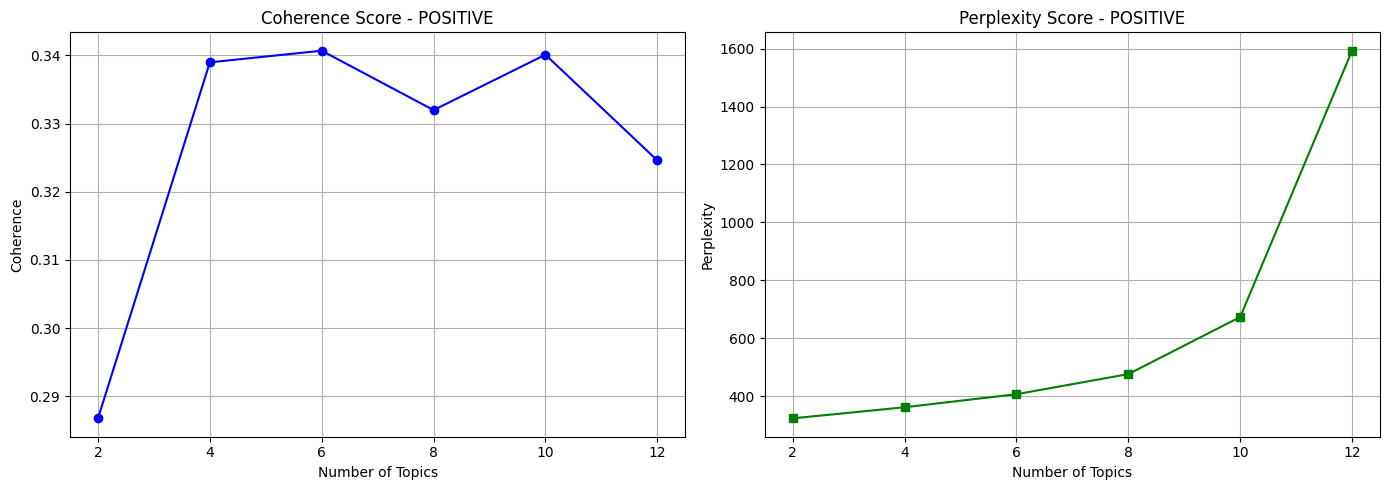

In [ ]:
# 주의: 약 1시간 걸림
pos_results = evaluate_lda_model(tokenized_pos_doc, pos_dictionary, pos_corpus, label="POSITIVE")
plot_lda_metrics(pos_results, label="POSITIVE")

[NEGATIVE] num_topics=2 | Coherence=0.3200 | Perplexity=339.33
[NEGATIVE] num_topics=4 | Coherence=0.3051 | Perplexity=383.91
[NEGATIVE] num_topics=6 | Coherence=0.3206 | Perplexity=426.96
[NEGATIVE] num_topics=8 | Coherence=0.3118 | Perplexity=496.31
[NEGATIVE] num_topics=10 | Coherence=0.3163 | Perplexity=720.99
[NEGATIVE] num_topics=12 | Coherence=0.3239 | Perplexity=1710.20


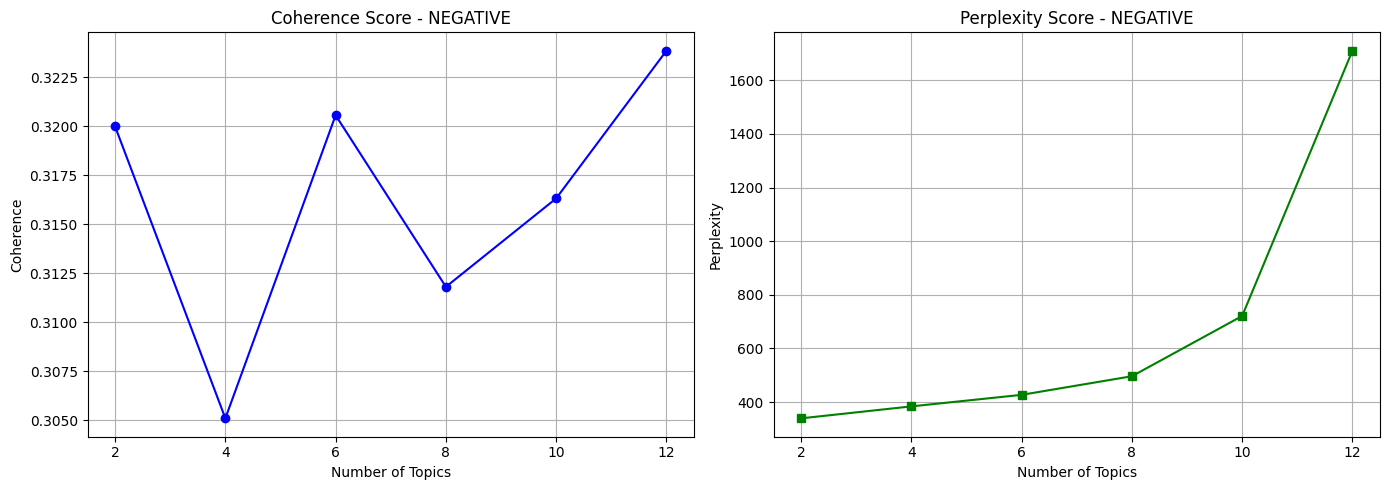

In [ ]:
# 주의: 약 1시간 걸림
neg_results = evaluate_lda_model(tokenized_neg_doc, neg_dictionary, neg_corpus, label="NEGATIVE")
plot_lda_metrics(neg_results, label="NEGATIVE")

In [14]:
# 최종 토픽 수 지정
pos_num_topics = 6
neg_num_topics = 6

# LDA 모델 생성
pos_ldamodel = LdaModel(pos_corpus, num_topics=pos_num_topics, id2word=pos_dictionary, passes=4, alpha='symmetric', eta='auto', random_state=100)
neg_ldamodel = LdaModel(neg_corpus, num_topics=neg_num_topics, id2word=neg_dictionary, passes=4, alpha='symmetric', eta='auto', random_state=100)

In [21]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pos_vis = pyLDAvis.gensim_models.prepare(pos_ldamodel, pos_corpus, pos_dictionary)
pyLDAvis.display(pos_vis)

In [ ]:
pyLDAvis.enable_notebook()
neg_vis = pyLDAvis.gensim_models.prepare(neg_ldamodel, neg_corpus, neg_dictionary)
pyLDAvis.display(neg_vis)

In [17]:
# 토픽별 키워드와 가중치를 데이터 프레임으로
pos_topics_df = pd.DataFrame()

for i, topic in enumerate(pos_ldamodel.show_topics(formatted=False, num_words=40)):
    topic_keywords = ", ".join([word for word, prop in topic[1]])
    pos_topics_df = pd.concat([pos_topics_df, pd.DataFrame({'Topic_Num': "Topic " + str(i+1),
                                                    'Keywords': topic_keywords}, index=[0])], ignore_index=True)

print(pos_topics_df)

  Topic_Num  \
0   Topic 1   
1   Topic 2   
2   Topic 3   
3   Topic 4   
4   Topic 5   
5   Topic 6   

                                                                                                                                                                                                  Keywords  
0  movi, film, best, year, comedi, time, funni, good, big, enjoy, great, screen, charm, watch, anim, heart, comic, sweet, littl, romant, age, book, way, music, summer, thing, famili, entertain, fun, ...  
1  film, war, thriller, x, effect, visual, drama, action, work, anim, seri, piec, director, product, disney, filmmak, craft, stori, style, genr, crime, invent, polit, beauti, entertain, simpl, epic, ...  
2  movi, full, film, good, review, spanish, fun, horror, action, old, new, time, genr, comedi, entertain, lot, fan, great, zombi, much, sequel, laugh, way, bad, deliv, zombieland, origin, end, fashio...  
3  film, stori, charact, life, way, movi, world, human, work, time, beauti

In [18]:
neg_topics_df = pd.DataFrame()

for i, topic in enumerate(neg_ldamodel.show_topics(formatted=False, num_words=40)):
    topic_keywords = ", ".join([word for word, prop in topic[1]])
    neg_topics_df = pd.concat([neg_topics_df, pd.DataFrame({'Topic_Num': "Topic " + str(i+1),
                                                    'Keywords': topic_keywords}, index=[0])], ignore_index=True)

print(neg_topics_df)

  Topic_Num  \
0   Topic 1   
1   Topic 2   
2   Topic 3   
3   Topic 4   
4   Topic 5   
5   Topic 6   

                                                                                                                                                                                                  Keywords  
0  movi, film, time, good, bad, thing, much, charact, watch, way, minut, end, realli, hour, feel, mani, lot, idea, peopl, stori, funni, half, plot, hard, enough, littl, tri, look, get, actual, work, ...  
1  film, stori, charact, lack, movi, perform, plot, action, ultim, much, despit, littl, feel, visual, product, interest, fall, work, emot, game, gener, moment, narr, act, script, end, way, disappoint...  
2  movi, film, men, war, world, white, old, new, high, age, wild, audienc, x, life, look, women, littl, middl, eye, stori, school, much, truli, youth, zooland, young, teen, girl, play, feel, hard, ma...  
3  director, writer, hand, film, actor, script, star, perform, aw, man, mi

In [ ]:
import pandas as pd
import sys

# 토픽 비율 추출
def extract_dominant_topics(ldamodel, corpus):
    doc_topic_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = sorted(row_list, key=lambda x: x[1], reverse=True)
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, _ in wp])
        doc_topic_df = pd.concat([
            doc_topic_df,
            pd.DataFrame({'Document_No': i,
                          'Dominant_Topic': topic_num,
                          'Topic_Perc_Contrib': prop_topic,
                          'Keywords': topic_keywords}, index=[0])
        ], ignore_index=True)
    return doc_topic_df

# 문서별 토픽 비율
def get_topic_percentages(ldamodel, corpus):
    topic_percentages_list = []
    for doc_bow in corpus:
        topic_percs = [0] * ldamodel.num_topics
        for topic_num, perc in ldamodel.get_document_topics(doc_bow, minimum_probability=0):
            topic_percs[topic_num] = round(perc, 6)
        topic_percentages_list.append(topic_percs)
    return topic_percentages_list

# 문서 추출
def top_documents_per_topic(ldamodel, corpus, tokenized_doc):
    doc_topics = [ldamodel.get_document_topics(bow) for bow in corpus]
    top_docs = {}
    for i, topic_dist in enumerate(doc_topics):
        for topic_num, topic_prob in topic_dist:
            if topic_num not in top_docs or top_docs[topic_num][1] < topic_prob:
                top_docs[topic_num] = (i, topic_prob)
    for topic_num, (doc_idx, prob) in sorted(top_docs.items()):
        # 생략 없이 출력
        sys.stdout.write(f"Topic {topic_num}: Document Index = {doc_idx}, Probability = {prob}\n")
        sys.stdout.write("Document: " + " ".join(tokenized_doc.iloc[doc_idx]) + "\n")
        sys.stdout.write("-" * 80 + "\n")


In [ ]:
# POSITIVE (주의: 약 2시간 걸림)
pos_doc_topics_df = extract_dominant_topics(pos_ldamodel, pos_corpus)
pos_topic_percs = get_topic_percentages(pos_ldamodel, pos_corpus)
top_documents_per_topic(pos_ldamodel, pos_corpus, tokenized_pos_doc)

Topic 0: Document Index = 81592, Probability = 0.9443333745002747
Document: arthur christma christma famili movi last sever year fun kid adult feel kid watch
--------------------------------------------------------------------------------
Topic 1: Document Index = 462768, Probability = 0.9356608986854553
Document: intrigu power previou anim featur seoul station visual narr perpetu grip motion
--------------------------------------------------------------------------------
Topic 2: Document Index = 41872, Probability = 0.9403570890426636
Document: dead good old fashion horror movi fan classic monster movi thing bump night
--------------------------------------------------------------------------------
Topic 3: Document Index = 542051, Probability = 0.9477232694625854
Document: stori film tell less import way watch experienc moment truth confront idea realiti life turn
--------------------------------------------------------------------------------
Topic 4: Document Index = 531016, Proba

In [ ]:
pd.set_option('display.max_colwidth', None)

# NEGATIVE (주의: 약 1시간 걸림)
neg_doc_topics_df = extract_dominant_topics(neg_ldamodel, neg_corpus)
neg_topic_percs = get_topic_percentages(neg_ldamodel, neg_corpus)
top_documents_per_topic(neg_ldamodel, neg_corpus, tokenized_neg_doc)

Topic 0: Document Index = 368352, Probability = 0.947820246219635
Document: play realli realli realli realli realli realli realli realli realli realli realli bad tv show
--------------------------------------------------------------------------------
Topic 1: Document Index = 85610, Probability = 0.943928599357605
Document: big fan messag film contriv plot melodrama whole point film viewer feel much drama
--------------------------------------------------------------------------------
Topic 2: Document Index = 4036, Probability = 0.9507424235343933
Document: piecem earnest fault remak georg cukor film elit world humorless filthi rich new york women fan
--------------------------------------------------------------------------------
Topic 3: Document Index = 372209, Probability = 0.9724944829940796
Document: prospathei peisei oti kanei tainia poy dagkonei systima tin poy anthropo poy eih grapsei biblio sti ton peristatikon toy biografimato toy se senario kanei ayto poy epi eton na mathe